In [1]:
# !conda install -y -c conda-forge pymc3

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
data = pd.read_csv("./data/sales-of-shampoo-over-a-three-ye.csv").dropna()
data = data.rename(columns={"Sales of shampoo over a three year period": "sales"})
sales = data["sales"]

<AxesSubplot:>

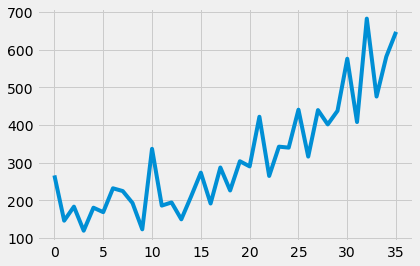

In [4]:
sales.plot()

In [5]:
X = sales.index.to_numpy().reshape(-1,1)
y = sales.to_numpy()

# frequentist approach

<AxesSubplot:>

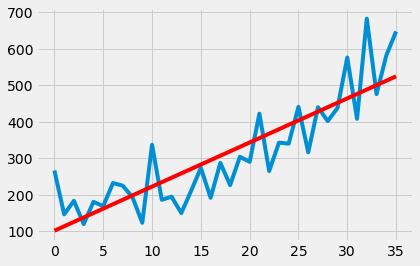

In [6]:
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
sales.plot()
pd.Series(y_pred).plot(color='red')

In [7]:
reg.coef_, reg.intercept_

(array([12.07907336]), 101.2162162162162)

<AxesSubplot:>

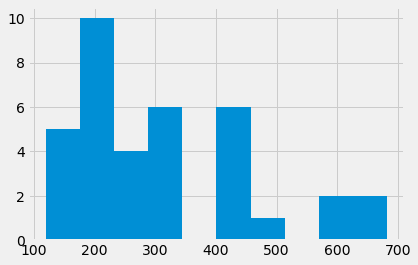

In [25]:
pd.Series(y).hist()

# bayesian approach

In [41]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
#     sigma = pm.Uniform("sigma", 0,100)
    intercept = pm.Normal("intercept", mu=100, sigma=10)
    slope = pm.Normal("slope", mu=12, sigma=10)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * X.flatten(), sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [slope, intercept, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 7 seconds.


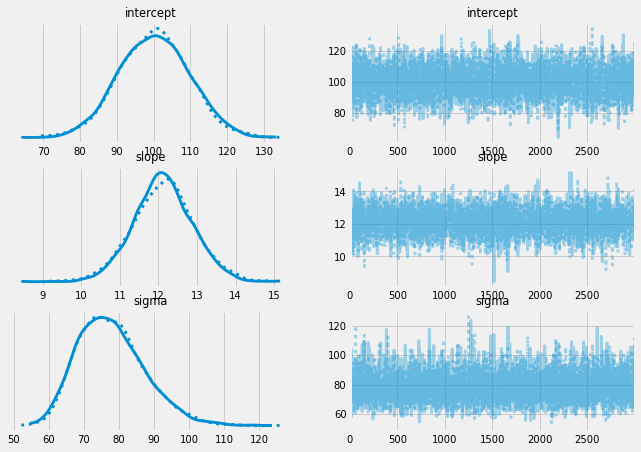

In [42]:
# show marginal distributions of the parameters
az.plot_trace(trace, figsize=(10, 7));

In [43]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["intercept", "slope", "y"],
    )

In [44]:
y_b = np.array([s*X+i for s, i in zip(ppc["slope"], ppc["intercept"])])

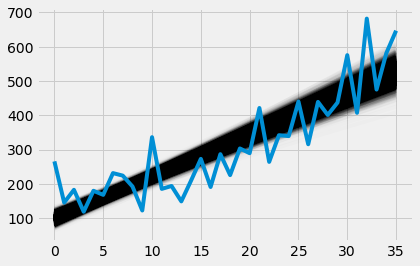

In [45]:
fig, ax = plt.subplots()
ax.plot(X[:,0], y_b[..., 0].T, color="k", alpha=0.01)
ax.plot(X,y)
plt.show()
